In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import keras_tuner as kt
from tensorflow.keras.metrics import RootMeanSquaredError, R2Score


df_not_outliers = pd.read_csv('../intermedio_sin_outliers.csv')

X_sin_outliers = df_not_outliers.drop(columns=['Precio_usd'])
y_sin_outliers = df_not_outliers['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled_sin_outliers = scaler.fit_transform(X_sin_outliers)

# Split sin outliers
X_train_sin_outliers, X_test_sin_outliers, y_train_sin_outliers, y_test_sin_outliers = train_test_split(
    X_scaled_sin_outliers, y_sin_outliers, test_size=0.2, random_state=42
)


/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Modelo
def build_model2(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train_sin_outliers.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=[
            'mae',
            RootMeanSquaredError(name='rmse'),
            R2Score(name='r2')
        ]
    )
    return model

# Tuner
tuner2 = kt.RandomSearch(
    build_model2,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar mejores hiperparámetros
tuner2.search(
    X_train_sin_outliers, y_train_sin_outliers,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Mejor modelo
best_model_sinOutlier = tuner2.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 00m 15s]
val_mae: 2283.230712890625

Best val_mae So Far: 2247.729736328125
Total elapsed time: 00h 02m 36s


/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [3]:
# Recuperar los mejores hiperparámetros
best_hp3 = tuner2.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model2 = build_model2(best_hp3)
history2 = model2.fit(
    X_train_sin_outliers, y_train_sin_outliers,
    validation_data=(X_test_sin_outliers, y_test_sin_outliers),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 15583.3467 - mae: 15574.9805 - r2: -2.5950 - rmse: 19209.7539 - val_loss: 5037.6914 - val_mae: 5016.2773 - val_r2: 0.5903 - val_rmse: 6843.9028
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 4621.6689 - mae: 4599.4824 - r2: 0.6078 - rmse: 6538.4331 - val_loss: 3500.2512 - val_mae: 3475.7195 - val_r2: 0.7578 - val_rmse: 5262.3047
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 3951.9329 - mae: 3927.0322 - r2: 0.7158 - rmse: 5589.2612 - val_loss: 3619.6567 - val_mae: 3593.3750 - val_r2: 0.7781 - val_rmse: 5037.0537
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 3786.1248 - mae: 3759.7993 - r2: 0.7492 - rmse: 5252.2373 - val_loss: 2640.9700 - val_mae: 2614.1243 - val_r2: 0.8658 - val_rmse: 3916.3499
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 3669.5117 - mae: 3642.7002 - r2: 0.7707 - rmse: 5028.2642 - val_loss: 2590.8499 - val_mae: 2563.7227 - val_r2: 0.8696 - val_rmse

In [4]:
print (best_hp3.values)
print (best_hp3)

{'units_1': 256, 'dropout_1': 0.30000000000000004, 'units_2': 112, 'dropout_2': 0.4, 'units_3': 64, 'lr': 0.01}


In [5]:
y_pred = model2.predict(X_test_sin_outliers).flatten()

mae = mean_absolute_error(y_test_sin_outliers, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_sin_outliers, y_pred))
r2 = r2_score(y_test_sin_outliers, y_pred)
mape = np.mean(np.abs((y_test_sin_outliers - y_pred) / y_test_sin_outliers)) * 100

print(f"\n--- MÉTRICAS ---")
print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R2: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")



106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step

--- MÉTRICAS ---
MAE: $2,368
RMSE: $3,599
R2: 0.887
MAPE: 10.37%


In [6]:
dataset1 = pd.read_csv('../dataset_basico.csv')

X1, y1 = dataset1.drop(columns='Precio_usd'), dataset1['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X1)

# Split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled, y1, test_size=0.2, random_state=42)


In [7]:
# Modelo
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train1.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=[
            'mae',
            RootMeanSquaredError(name='rmse'),
            R2Score(name='r2')
        ]
    )
    return model

# Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar
tuner.search(X_train1, y_train1, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 14s]
val_mae: 3172.394287109375

Best val_mae So Far: 3107.122314453125
Total elapsed time: 00h 02m 27s


/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [8]:
y_pred = best_model.predict(X_test1).flatten()

mae = mean_absolute_error(y_test1, y_pred)
rmse = np.sqrt(mean_squared_error(y_test1, y_pred))
r2 = r2_score(y_test1, y_pred)
mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100

print(f"\n--- MÉTRICAS ---")
print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R2: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step

--- MÉTRICAS ---
MAE: $3,023
RMSE: $4,670
R2: 0.807
MAPE: 12.66%


In [9]:
# Recuperar los mejores hiperparámetros
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model1 = build_model(best_hp)
history1 = model1.fit(
    X_train1, y_train1,
    validation_data=(X_test1, y_test1),
    epochs=50,
    batch_size=32,
    verbose=1
)
print(best_hp.values)
print(best_hp)

/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step - loss: 17659.2715 - mae: 17655.0293 - r2: -3.1536 - rmse: 21413.8809 - val_loss: 3606.9670 - val_mae: 3594.9121 - val_r2: 0.7603 - val_rmse: 5200.5620
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 4222.7646 - mae: 4210.6650 - r2: 0.6791 - rmse: 5997.6133 - val_loss: 3347.5073 - val_mae: 3335.3086 - val_r2: 0.7828 - val_rmse: 4949.8901
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 4159.2598 - mae: 4147.0010 - r2: 0.6846 - rmse: 5974.4717 - val_loss: 3731.6729 - val_mae: 3719.4336 - val_r2: 0.7361 - val_rmse: 5456.6104
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - loss: 4079.4172 - mae: 4067.0215 - r2: 0.7048 - rmse: 5793.9287 - val_loss: 3233.4297 - val_mae: 3220.8047 - val_r2: 0.7921 - val_rmse: 4843.0391
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 4017.7458 - mae: 4005.2083 - r2: 0.6925 - rmse: 5784.0601 - val_loss: 3321.1084 - val_mae: 3308.5652 - val_r2: 0.6315 - val_rm

In [10]:
dataset1 = pd.read_csv('../dataset_final.csv')

X2, y2 = dataset1.drop(columns='Precio_usd'), dataset1['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled2 = scaler.fit_transform(X2)

# Split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled2, y2, test_size=0.2, random_state=42)


In [11]:
# Modelo
def build_model3(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train2.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=[
            'mae',
            RootMeanSquaredError(name='rmse'),
            R2Score(name='r2')
        ]
    )
    return model

# Tuner
tuner3 = kt.RandomSearch(
    build_model3,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar
tuner3.search(X_train2, y_train2, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Mejor modelo
best_model = tuner3.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 17s]
val_mae: 6091.509765625

Best val_mae So Far: 2579.478759765625
Total elapsed time: 00h 02m 30s


/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
# Recuperar los mejores hiperparámetros
best_hp3 = tuner3.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model3 = build_model3(best_hp3)
history3 = model3.fit(
    X_train2, y_train2,
    validation_data=(X_test2, y_test2),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


/Users/matiaslein/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 903us/step - loss: 24594.1016 - mae: 24593.8398 - r2: -5.4727 - rmse: 26738.1191 - val_loss: 23912.3750 - val_mae: 23911.5625 - val_r2: -4.9514 - val_rmse: 26083.4512
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 23070.2031 - mae: 23068.9180 - r2: -4.7599 - rmse: 25128.9746 - val_loss: 18887.0449 - val_mae: 18883.7246 - val_r2: -2.8516 - val_rmse: 20983.4043
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 16904.3789 - mae: 16900.0859 - r2: -2.3354 - rmse: 19124.1699 - val_loss: 10126.6318 - val_mae: 10119.0967 - val_r2: -0.5376 - val_rmse: 13257.8740
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9201.7246 - mae: 9193.0605 - r2: -0.3054 - rmse: 11961.5303 - val_loss: 5205.6753 - val_mae: 5194.1846 - val_r2: 0.5311 - val_rmse: 7321.5806
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 6032.0029 - mae: 6020.1782 - r2: 0.4502 - rmse: 7767.9819 - val_loss: 3689.3230 - val_mae: 3676.9971 - val_r2: 0.7522

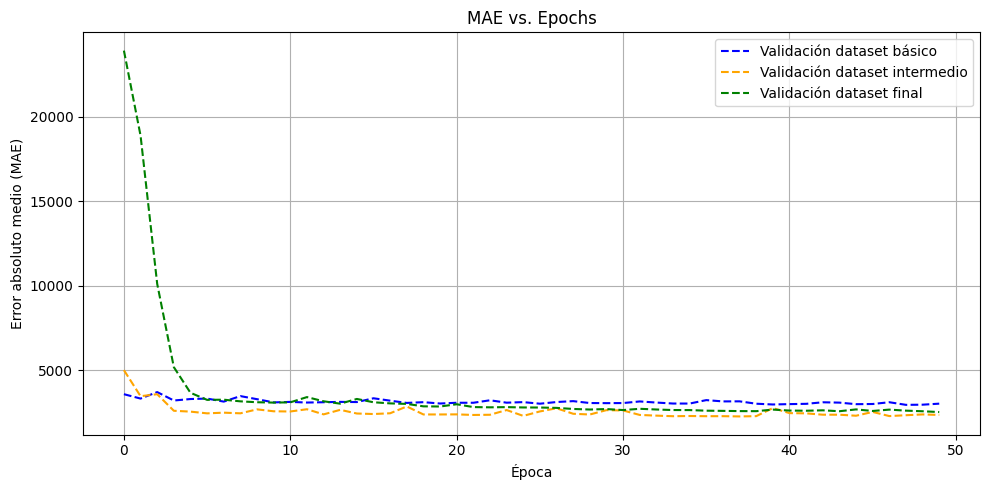

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
#plt.plot(history1.history['mae'], label='Entrenamiento dataset básico',color='blue')
plt.plot(history1.history['val_mae'], label='Validación dataset básico', linestyle='--', color='blue')
#plt.plot(history2.history['mae'], label='Entrenamiento dataset intermedio',color='Orange')
plt.plot(history2.history['val_mae'], label='Validación dataset intermedio',color='Orange', linestyle='--')
#plt.plot(history3.history['mae'], label='Entrenamiento dataset final',color='green')
plt.plot(history3.history['val_mae'], label='Validación dataset final', linestyle='--', color='green')
plt.title('MAE vs. Epochs')
plt.xlabel('Época')
plt.ylabel('Error absoluto medio (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


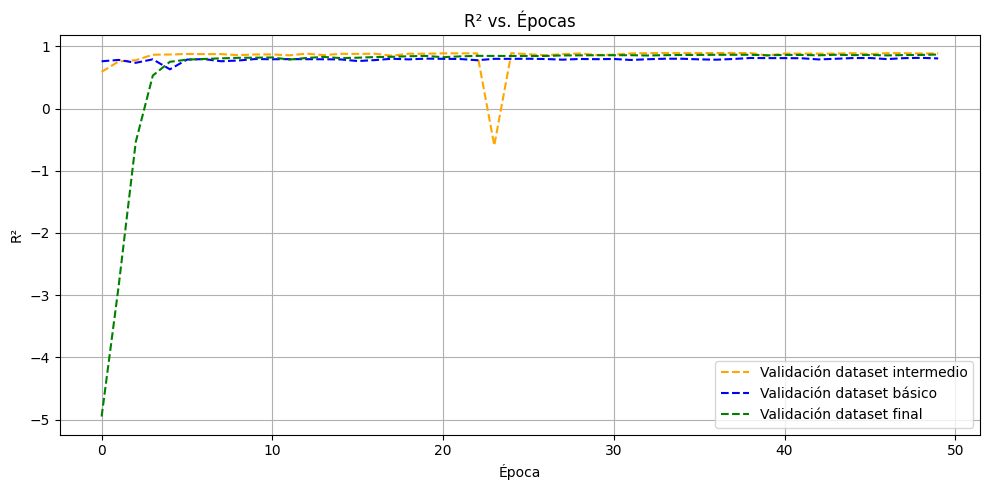

In [26]:
plt.figure(figsize=(10, 5))
#plt.plot(history2.history['r2'], label='Entrenamiento dataset intermedio', color='orange')
plt.plot(history2.history['val_r2'], label='Validación dataset intermedio', linestyle='--', color='orange')
#plt.plot(history1.history['r2'], label='Entrenamiento dataset básico', color='blue')
plt.plot(history1.history['val_r2'], label='Validación dataset básico', linestyle='--', color='blue')
#plt.plot(history3.history['r2'], label='Entrenamiento dataset final', color='green')
plt.plot(history3.history['val_r2'], label='Validación dataset final', linestyle='--', color='green')
plt.title('R² vs. Épocas')
plt.xlabel('Época')
plt.ylabel('R²')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

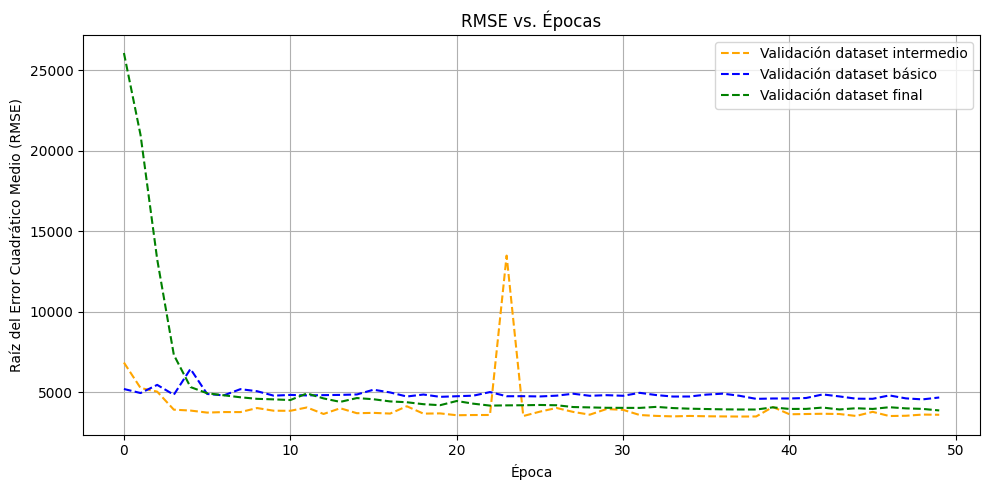

In [27]:
plt.figure(figsize=(10, 5))
#plt.plot(history2.history['rmse'], label='Entrenamiento dataset intermedio', color='orange')
plt.plot(history2.history['val_rmse'], label='Validación dataset intermedio', linestyle='--', color='orange')
#plt.plot(history1.history['rmse'], label='Entrenamiento dataset básico', color='blue')
plt.plot(history1.history['val_rmse'], label='Validación dataset básico', linestyle='--', color='blue')
#plt.plot(history3.history['rmse'], label='Entrenamiento dataset final', color='green')
plt.plot(history3.history['val_rmse'], label='Validación dataset final', linestyle='--', color='green')
plt.title('RMSE vs. Épocas')
plt.xlabel('Época')
plt.ylabel('Raíz del Error Cuadrático Medio (RMSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
from tabulate import tabulate
import pandas as pd
import numpy as np

# Supone que ya tenés mae, rmse, r2, history1, history2, history3 definidos

metrics = {
    'Modelo': ['Básico', 'Intermedio', 'Final'],
    'MAE': [
        np.mean(history1.history['mae']),
        np.mean(history2.history['mae']),
        np.mean(history3.history['mae']),
    ],
    'RMSE': [
        np.mean(history1.history['rmse']),
        np.mean(history2.history['rmse']),
        np.mean(history3.history['rmse']),
    ],
    'R²': [
        np.mean(history1.history['r2']),
        np.mean(history2.history['r2']),
        np.mean(history3.history['r2']),
    ],
}

df_metrics = pd.DataFrame(metrics)

# Imprimir en formato tabla bonito
print(tabulate(df_metrics, headers='keys', tablefmt='fancy_grid', showindex=False))



╒════════════╤═════════╤═════════╤══════════╕
│ Modelo     │     MAE │    RMSE │       R² │
╞════════════╪═════════╪═════════╪══════════╡
│ Básico     │ 3950.41 │ 5758.25 │ 0.685711 │
├────────────┼─────────┼─────────┼──────────┤
│ Intermedio │ 3381.76 │ 4743.24 │ 0.780412 │
├────────────┼─────────┼─────────┼──────────┤
│ Final      │ 5132.06 │ 6630.18 │ 0.433404 │
╘════════════╧═════════╧═════════╧══════════╛


In [29]:
## prediciones con dataset final 
#importar 
import pandas as pd
dataset_final = pd.read_csv('../pf_dataset_test_final.csv')
print(dataset_final.dtypes)

#predicciones
predicciones = model2.predict(dataset_final).flatten()

df_predicciones = pd.DataFrame({'prediccion': predicciones})

# Exportar a CSV
df_predicciones.to_csv('predicciones_MLP.csv', index=False)

Año                           float64
Puertas                       float64
Con cámara de retroceso       float64
Kilómetros                    float64
Marca_Alfa Romeo              float64
                               ...   
Transmision_Manual            float64
Transmision_Semiautomática    float64
Vendedor_concesionaria        float64
Vendedor_particular           float64
Vendedor_tienda               float64
Length: 92, dtype: object
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
